# Fit the Composite Spectra

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool

import mfp
import emcee
import corner
from astropy.io import fits
from astropy.table import Table


In [2]:
# find the data files
snr_cut = 3
wvmin = 800
files_all = os.listdir('./data/specs/')
files = np.sort([f for f in files_all if re.match(f'spec_[0-9.]*-[0-9.]*_snr{snr_cut}_even_zerr_0\.5A.npz', f)])
print(files)

['spec_3.200-3.236_snr3_even_zerr_0.5A.npz'
 'spec_3.236-3.275_snr3_even_zerr_0.5A.npz'
 'spec_3.275-3.320_snr3_even_zerr_0.5A.npz'
 'spec_3.320-3.364_snr3_even_zerr_0.5A.npz'
 'spec_3.364-3.415_snr3_even_zerr_0.5A.npz'
 'spec_3.415-3.474_snr3_even_zerr_0.5A.npz'
 'spec_3.474-3.539_snr3_even_zerr_0.5A.npz'
 'spec_3.539-3.613_snr3_even_zerr_0.5A.npz'
 'spec_3.613-3.696_snr3_even_zerr_0.5A.npz'
 'spec_3.696-3.756_snr3_even_zerr_0.5A.npz'
 'spec_3.756-3.808_snr3_even_zerr_0.5A.npz'
 'spec_3.808-3.866_snr3_even_zerr_0.5A.npz'
 'spec_3.866-3.931_snr3_even_zerr_0.5A.npz'
 'spec_3.931-4.024_snr3_even_zerr_0.5A.npz'
 'spec_4.024-4.161_snr3_even_zerr_0.5A.npz'
 'spec_4.161-4.434_snr3_even_zerr_0.5A.npz'
 'spec_4.434-4.600_snr3_even_zerr_0.5A.npz']


In [3]:
# Fiducial Model with DESI data and T02 template
def fit(filename):
    data = np.load(f'./data/specs/{filename}')
    wave_fin = data['wave_fin']
    flux_tot = data['flux_tot']
    flux_boot = data['flux_boot']
    flux_telfer = data['flux_telfer']
    error_tot = data['error_tot']
    zmed = data['zmed']
    z_interval = data['z_interval']

    model = mfp.model.Fiducial(mcmc_params={"init":(1, 200), "prior":((0., 3.), (0., 1000.)),
                                    "run_params":{"nwalkers":32, "nsteps":300, "nburn":200}})

    sample, samplers, model = mfp.fitting.model_fit(wave_fin, flux_tot, error_tot, flux_telfer=flux_telfer,
                                                    zmed=zmed, wvmin=wvmin, wvmax=912, method='mcmc',
                                                    model=model, flux_boot=flux_boot)

    return zmed, sample, samplers, model

results = []
for i in tqdm(range(len(files))):
    results.append(fit(files[i]))

zmeds_fid = np.array([r[0] for r in results])
samples_fid = np.array([r[1] for r in results])
samplers_fid = np.array([r[2] for r in results])
models_fid = np.array([r[3] for r in results])


100%|██████████| 17/17 [35:33<00:00, 125.47s/it]


In [4]:
# calculate MFP and save the file
def helper(model, s):
    return model.mfp_calculation(s)

mfps_fid = []
for i in range(17):
    indices = np.random.choice(range(samples_fid.shape[1]), 200000, replace=True)
    sample = samples_fid[i][indices]
    model = models_fid[i]
    with Pool(10) as p:
        mfp_this = p.starmap(helper, tqdm([(model, s) for s in sample]))
    mfps_fid.append(mfp_this)

np.savez('./data/sample_DESI_Fiducial_350.npz', zmeds=zmeds_fid, samples=samples_fid, samplers=samplers_fid, models=models_fid, mfps=mfps_fid)

100%|██████████| 200000/200000 [00:36<00:00, 5521.33it/s] 


In [5]:
# SDSS Data remeasurements with Fiducial Model
files_sdss = np.sort(np.array([file for file in os.listdir('./data/previous/') if re.match('^.*DR7.*$', file)]))[-7:]
print(files_sdss)
df_telfer = pd.read_csv('./data/telfer.asc', comment='#', delimiter='\s+', header=None)
cat = Table(fits.open('./data/previous/sdss_mfp_summ.fits')[1].data[-7:])

def fit(filename):
    data = fits.open(f'./data/previous/{filename}')
    wave_fin = data[2].data
    flux_tot = data[0].data
    flux_boot = data[3].data.T
    error_tot = data[1].data / np.sqrt(150)
    zmed = cat['ZQSO'][i]
    z_interval = cat['ZMNX'][i]

    z912 = wave_fin/912 * (1+zmed) - 1
    mask = (z912<zmed) & (z912>zmed-0.4) & (wave_fin<905) & (wave_fin*(1+zmed)>3900)
    wvmin = np.min(wave_fin[mask])

    flux_telfer = mfp.utils.telfer(wave_fin, np.array(df_telfer[0]), np.array(df_telfer[1]))

    model = mfp.model.Fiducial(mcmc_params={"init":(1, 200), "prior":((0., 3.), (0., 1000.)),
                                    "run_params":{"nwalkers":32, "nsteps":300, "nburn":200}})

    sample, samplers, model = mfp.fitting.model_fit(wave_fin, flux_tot, error_tot, flux_telfer=flux_telfer, flux_boot=flux_boot,
                                                    zmed=zmed, wvmin=wvmin, wvmax=912, method='mcmc', model=model)

    return zmed, sample, samplers, model

results = []
for i in tqdm(range(len(files_sdss))):
    results.append(fit(files_sdss[i]))

zmeds_sdss = np.array([r[0] for r in results])
samples_sdss = np.array([r[1] for r in results])
samplers_sdss = np.array([r[2] for r in results])
models_sdss = np.array([r[3] for r in results])

def helper(model, s):
    return model.mfp_calculation(s)

mfps_sdss = []
for i in range(samples_sdss.shape[0]):
    indices = np.random.choice(range(samples_sdss.shape[1]), 200000, replace=True)
    sample = samples_sdss[i][indices]
    model = models_sdss[i]
    with Pool(10) as p:
        mfp_this = p.starmap(helper, tqdm([(model, s) for s in sample]))
    mfps_sdss.append(mfp_this)

np.savez('./data/sample_SDSS_remeasure.npz', zmeds=zmeds_sdss, samples=samples_sdss, samplers=samplers_sdss, models=models_sdss, mfps=mfps_sdss)

['stack_DR7_z3.71_z3.76.fits' 'stack_DR7_z3.76_z3.81.fits'
 'stack_DR7_z3.81_z3.86.fits' 'stack_DR7_z3.86_z3.92.fits'
 'stack_DR7_z3.92_z4.02.fits' 'stack_DR7_z4.02_z4.13.fits'
 'stack_DR7_z4.13_z4.34.fits']


100%|██████████| 200000/200000 [00:32<00:00, 6221.86it/s] 


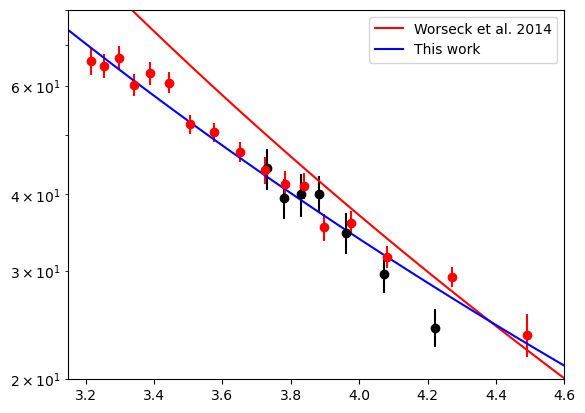

In [6]:
plt.errorbar(zmeds_sdss, [np.mean(m) for m in mfps_sdss], yerr=[np.std(m) for m in mfps_sdss], fmt='o', color='k')
plt.errorbar(zmeds_fid, [np.mean(m) for m in mfps_fid], yerr=[np.std(m) for m in mfps_fid], fmt='o', color='r')
zs = np.linspace(2, 5, 100)
mfp_W14 = 37 * ((1 + zs) / 5)**(-5.4)
mfp_me = 33.87 * ((1 + zs) / 5)**(-4.2)
plt.plot(zs, mfp_W14, color='r', label='Worseck et al. 2014')
plt.plot(zs, mfp_me, color='b', label='This work')
plt.yscale('log')
plt.xlim(3.15, 4.6)
plt.ylim(20, 80)
plt.legend()
plt.show()